### Imports

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
import os
import matplotlib.pyplot as plt
import seaborn as sns

Matplotlib is building the font cache; this may take a moment.


## Data Merging

### Load datasets

In [3]:
data_files = os.path.join(os.getcwd(), "..", "data", "original") #Alter accordingly if needed
accounts_df = pd.read_csv(os.path.join(data_files, "accounts.csv"))
products_df = pd.read_csv(os.path.join(data_files, "products.csv"))
sales_pipeline_df = pd.read_csv(os.path.join(data_files, "sales_pipeline.csv"))
sales_teams_df = pd.read_csv(os.path.join(data_files, "sales_teams.csv"))

### Remove duplicates



In [4]:
accounts_df.drop_duplicates(inplace=True)
products_df.drop_duplicates(inplace=True)
sales_pipeline_df.drop_duplicates(inplace=True)
sales_teams_df.drop_duplicates(inplace=True)

Fixing this issue: Sales pipeline product column is "GTXPro" without a space, while product's product has "GTX Pro" with space.

In [5]:
sales_pipeline_df['product'] = sales_pipeline_df['product'].replace("GTXPro", "GTX Pro")

In [6]:
#Verifying that worked as intended
print(sales_pipeline_df['product'].unique())

['GTX Plus Basic' 'GTX Pro' 'MG Special' 'GTX Basic' 'MG Advanced'
 'GTX Plus Pro' 'GTK 500']


### Merge datasets

In [7]:
merged_df = (
  sales_pipeline_df
  .merge(sales_teams_df, on="sales_agent", how="left")
  .merge(products_df, on="product", how="left")
  .merge(accounts_df, on="account", how="left")
)
print(merged_df.shape)
merged_df.head(10)

(8800, 18)


,opportunity_id,sales_agent,product,account,deal_stage,engage_date,close_date,close_value,manager,regional_office,series,sales_price,sector,year_established,revenue,employees,office_location,subsidiary_of
0,1C1I7A6R,Moses Frase,GTX Plus Basic,Cancity,Won,2016-10-20,2017-03-01,1054.0,Dustin Brinkmann,Central,GTX,1096,retail,2001.0,718.62,2448.0,United States,NaN
1,Z063OYW0,Darcel Schlecht,GTX Pro,Isdom,Won,2016-10-25,2017-03-11,4514.0,Melvin Marxen,Central,GTX,4821,medical,2002.0,3178.24,4540.0,United States,NaN
2,EC4QE1BX,Darcel Schlecht,MG Special,Cancity,Won,2016-10-25,2017-03-07,50.0,Melvin Marxen,Central,MG,55,retail,2001.0,718.62,2448.0,United States,NaN
3,MV1LWRNH,Moses Frase,GTX Basic,Codehow,Won,2016-10-25,2017-03-09,588.0,Dustin Brinkmann,Central,GTX,550,software,1998.0,2714.90,2641.0,United States,Acme Corporation
4,PE84CX4O,Zane Levy,GTX Basic,Hatfan,Won,2016-10-25,2017-03-02,517.0,Summer Sewald,West,GTX,550,services,1982.0,792.46,1299.0,United States,NaN
5,ZNBS69V1,Anna Snelling,MG Special,Ron-tech,Won,2016-10-29,2017-03-01,49.0,Dustin Brinkmann,Central,MG,55,medical,1992.0,3922.42,6837.0,United States,NaN
6,9ME3374G,Vicki Laflamme,MG Special,J-Texon,Won,2016-10-30,2017-03-02,57.0,Celia Rouche,West,MG,55,retail,1989.0,1388.67,3583.0,United States,NaN
7,7GN8Q4LL,Markita Hansen,GTX Basic,Cheers,Won,2016-11-01,2017-03-07,601.0,Celia Rouche,West,GTX,550,entertainment,1993.0,4269.90,6472.0,United States,Massive Dynamic
8,OLK9LKZB,Niesha Huffines,GTX Plus Basic,Zumgoity,Won,2016-11-01,2017-03-03,1026.0,Melvin Marxen,Central,GTX,1096,medical,1984.0,441.08,1210.0,United States,NaN
9,HAXMC4IX,James Ascencio,MG Advanced,NaN,Engaging,2016-11-03,NaN,NaN,Summer Sewald,West,MG,3393,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
merged_df.to_csv(os.path.join(os.getcwd(), "..", "data", "processed", "original_merged_data.csv"), index=False)

## Handling data before EDA

### Convert date columns to proper datetime format

In [9]:
merged_df["engage_date"]=pd.to_datetime(merged_df["engage_date"], errors="coerce")
merged_df["close_date"]=pd.to_datetime(merged_df["close_date"], errors="coerce")

### Handle missing values with mode/median imputation

In [10]:
categorical_columns = merged_df.select_dtypes(include="object").columns
numerical_columns = merged_df.select_dtypes(include="float64").columns
#Handling missing values in categorical variables with mode imputation
for col in categorical_columns:
  merged_df[col]=merged_df[col].fillna(merged_df[col].mode()[0])

#Handling missing values in numerical variables with median imputation
for col in numerical_columns:
  if col not in["close_value", "close_date", "engage_date"] : # close_value should not be replaced with fake values, since a null value means the deal hasn't been closed yet.
    merged_df[col] = merged_df[col].fillna(merged_df[col].median())

In [11]:
merged_df.isnull().sum()


opportunity_id         0
sales_agent            0
product                0
account                0
deal_stage             0
engage_date          500
close_date          2089
close_value         2089
manager                0
regional_office        0
series                 0
sales_price            0
sector                 0
year_established       0
revenue                0
employees              0
office_location        0
subsidiary_of          0
dtype: int64

## EDA on Original Dataset

In [12]:
# Summary statistics for numerical features
display(merged_df.describe().T)

# Summary statistics for categorical features however, only if any exist
cat_cols = merged_df.select_dtypes(include='object').columns
if len(cat_cols) > 0:
    display(merged_df[cat_cols].describe().T)
else:
    print("No categorical columns to summarize.")

#evaluate features most correlated with close_value (deals completed)
if "close_value" in merged_df.columns:
    corr = merged_df.corr(numeric_only=True)["close_value"].sort_values(ascending=False)
    display(corr)

,count,mean,min,25%,50%,75%,max,std
engage_date,8300,2017-06-14 08:35:06.216867584,2016-10-20 00:00:00,2017-04-04 00:00:00,2017-06-24 00:00:00,2017-08-27 00:00:00,2017-12-27 00:00:00,NaN
close_date,6711,2017-08-01 03:32:25.641484032,2017-03-01 00:00:00,2017-05-18 00:00:00,2017-08-02 00:00:00,2017-10-18 00:00:00,2017-12-31 00:00:00,NaN
close_value,6711.0,1490.915512,0.0,0.0,472.0,3225.0,30288.0,2320.670773
sales_price,8800.0,2379.109659,55.0,550.0,1096.0,4821.0,26768.0,2629.243384
year_established,8800.0,1995.405341,1979.0,1990.0,1995.0,2000.0,2017.0,8.412247
revenue,8800.0,2342.938873,4.54,718.62,1698.2,2819.5,11698.03,2393.473911
employees,8800.0,5343.471477,9.0,1588.0,3492.0,6472.0,34288.0,6293.18949


,count,unique,top,freq
opportunity_id,8800,8800,1C1I7A6R,1
sales_agent,8800,30,Darcel Schlecht,747
product,8800,7,GTX Basic,1866
account,8800,85,Hottechi,1625
deal_stage,8800,4,Won,4238
manager,8800,6,Melvin Marxen,1929
regional_office,8800,3,Central,3512
series,8800,3,GTX,5697
sector,8800,10,retail,2822
office_location,8800,15,United States,7545


close_value         1.000000
sales_price         0.679396
employees           0.035061
revenue             0.028136
year_established   -0.025376
Name: close_value, dtype: float64

Create new column for frequency graph

In [13]:
merged_df["has_close_date"] = merged_df["close_date"].notna().astype(int)
#Flagging deals without a close date
#Informative for Opportunity Win Prediction model, so that the model knows if the deal isn't closed yet

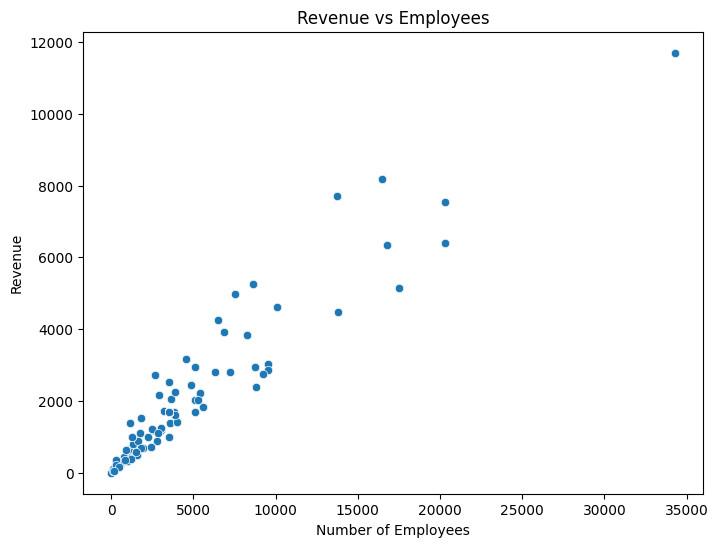

In [14]:
plt.figure(figsize=(8,6))
sns.scatterplot(data=merged_df, x="employees", y="revenue")
plt.title("Revenue vs Employees")
plt.xlabel("Number of Employees")
plt.ylabel("Revenue")
plt.show()
#Linear relationship between the number of employees and the revenue!

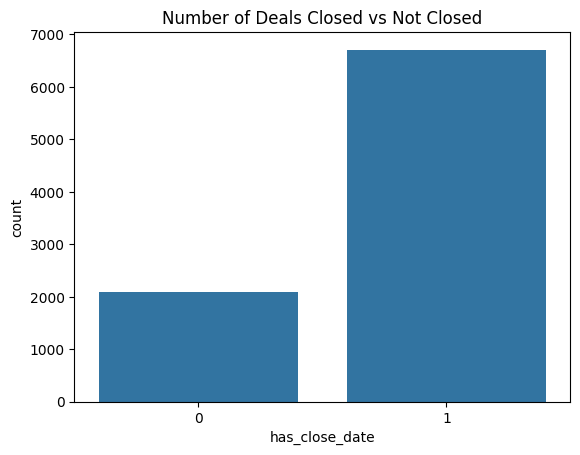

In [15]:
sns.countplot(x='has_close_date', data=merged_df)
plt.title("Number of Deals Closed vs Not Closed")
plt.show()

Summary of number of current missing values

In [16]:
missing_summary = merged_df.isnull().sum()
print(missing_summary[missing_summary > 0])

engage_date     500
close_date     2089
close_value    2089
dtype: int64


## Continuation of preprocessing

Standardize categorical values

In [17]:
for col in categorical_columns:
    merged_df[col] = merged_df[col].astype(str).str.strip().str.upper()

Handling outliers

In [18]:
for col in numerical_columns:
  if col != "close_value": #close_value should not be replaced with fake values, since a null value means the deal hasn't been closed yet.
    Q1 = merged_df[col].quantile(0.25)
    Q3 = merged_df[col].quantile(0.75)
    IQR = Q3-Q1

    lower_side = Q1 -1.5 *IQR
    upper_side = Q3 +1.5 * IQR

    merged_df[col]=merged_df[col].clip(lower=lower_side, upper=upper_side)

In [19]:
cols_to_log = ["close_value", "revenue", "employees"]

for col in cols_to_log:
    merged_df[col + "_log"] = np.log1p(merged_df[col])

merged_df[["close_value", "close_value_log",
           "revenue", "revenue_log",
           "employees", "employees_log"]].head()

,close_value,close_value_log,revenue,revenue_log,employees,employees_log
0,1054.0,6.961296,718.62,6.578723,2448.0,7.803435
1,4514.0,8.415160,3178.24,8.064397,4540.0,8.420903
2,50.0,3.931826,718.62,6.578723,2448.0,7.803435
3,588.0,6.378426,2714.90,7.906879,2641.0,7.879291
4,517.0,6.249975,792.46,6.676403,1299.0,7.170120


Encode categorical variables

In [20]:
label_enc = LabelEncoder()
cols_to_label_encode = ["sales_agent", "account", "office_location"] # only label encode columns that have too many unique values to one-hot encode

for col in cols_to_label_encode:
    merged_df[col] = label_enc.fit_transform(merged_df[col])
    
# Columns we will one-hot encode
cols_to_one_hot = ["product", "manager", "regional_office", "series", "sector", "subsidiary_of", "deal_stage"]

# Perform one-hot encoding using pandas.get_dummies
merged_df = pd.get_dummies(merged_df, columns=cols_to_one_hot, drop_first=False, dtype=int)

Standardize numerical variables

In [21]:
# Standardize numbers -> only sales price
scaler = StandardScaler()
merged_df["sales_price_scaled"] = scaler.fit_transform(merged_df[["sales_price"]])

Handling Year Established -> Binning into decade and then one-hot encoding

In [22]:
# Bin years into decades (e.g. 1996 → 1990s)
merged_df["year_established_decade"] = (
    (merged_df["year_established"] // 10).astype(int) * 10
).astype(str) + "s"

# One-hot encode the binned decades
merged_df = pd.get_dummies(
    merged_df,
    columns=["year_established_decade"],
    prefix="decade",
    prefix_sep="_"
    , dtype=int
)

Deriving temporal features

In [23]:

#These features can highlight patterns like deals closing faster in some months
#days_to_close can help with the opportunity win prediction model, as a longer vs. shorter deal cycle can be correlated with success

# Features derived from dates
merged_df["engage_year"] = merged_df["engage_date"].dt.year
merged_df["engage_month"] = merged_df["engage_date"].dt.month
merged_df["engage_dayofweek"] = merged_df["engage_date"].dt.dayofweek

#if there was no close date, then this will be NaN
merged_df["days_to_close"] = (merged_df["close_date"] - merged_df["engage_date"]).dt.days

#date/timeline features
if "engage_date" in merged_df.columns and "close_date" in merged_df.columns:
    #time between engagement and closing
    merged_df["days_to_close"] = (merged_df["close_date"] - merged_df["engage_date"]).dt.days
    #flag for deals closed within 30 days
    merged_df["closed_within_30d"] = merged_df["days_to_close"].apply(lambda x: 1 if pd.notnull(x) and x <= 30 else 0)

# Features derived from account, can be useful for Lead Scoring & Account Health models
current_year = pd.Timestamp.now().year
merged_df["account_age"] = current_year - merged_df["year_established"]


Deriving numerical values / statistical features

In [24]:
#Features derived from numerical columns
# Revenue per employee
merged_df["rev_per_employee"] = merged_df.apply(
    lambda x: x["revenue"] / x["employees"] if x["employees"] > 0 else np.nan, axis=1
)
#Can be used for account health scoring model, as accounts that have higher revenue for each employee can indicate stronger clients or more efficiency

In [25]:
#interaction count per account
if "account" in merged_df.columns:
    account_interaction_counts = merged_df.groupby("account").size().rename("account_interaction_count")
    merged = merged_df.merge(account_interaction_counts, on="account", how="left")

#num of deals closed by agent
if "sales_agent" in merged_df.columns and "close_date" in merged_df.columns:
    agent_closed_deals = merged_df[merged_df["close_date"].notnull()].groupby("sales_agent").size().rename("agent_closed_deals")
    merged_df = merged_df.merge(agent_closed_deals, on="sales_agent", how="left")
    merged_df["agent_closed_deals"] = merged_df["agent_closed_deals"].fillna(0)

#opportunity win rate by account
if "account" in merged_df.columns and "close_value" in merged_df.columns:
    merged_df["won_deal"] = merged_df["close_value"].notnull().astype(int)
    win_rate = merged_df.groupby("account")["won_deal"].mean().rename("account_win_rate")
    merged_df = merged_df.merge(win_rate, on="account", how="left")

#avg deal size by product
if "product" in merged_df.columns and "close_value" in merged_df.columns:
    avg_deal_size = merged_df.groupby("product")["close_value"].mean().rename("avg_deal_size_by_product")
    merged_df = merged_df.merge(avg_deal_size, on="product", how="left")

Filtering/dropping unnecessary columns

In [26]:
# opportunity_id is the only column safe to remove because it is a unique identifier and has no predictive or explanatory value for the model.
merged_df.drop(columns=["opportunity_id"], inplace=True)

### Verifying the new data

In [27]:
merged_df.isnull().sum()

sales_agent              0
account                  0
engage_date            500
close_date            2089
close_value           2089
                      ... 
account_age              0
rev_per_employee         0
agent_closed_deals       0
won_deal                 0
account_win_rate         0
Length: 70, dtype: int64

In [28]:
merged_df.shape

(8800, 70)

In [29]:
merged_df.head(10)

,sales_agent,account,engage_date,close_date,close_value,sales_price,year_established,revenue,employees,office_location,...,engage_year,engage_month,engage_dayofweek,days_to_close,closed_within_30d,account_age,rev_per_employee,agent_closed_deals,won_deal,account_win_rate
0,20,8,2016-10-20,2017-03-01,1054.0,1096,2001.0,718.62,2448.0,14,...,2016.0,10.0,3.0,132.0,0,24.0,0.293554,195,1,0.920792
1,6,38,2016-10-25,2017-03-11,4514.0,4821,2002.0,3178.24,4540.0,14,...,2016.0,10.0,1.0,137.0,0,23.0,0.700053,553,1,0.941176
2,6,8,2016-10-25,2017-03-07,50.0,55,2001.0,718.62,2448.0,14,...,2016.0,10.0,1.0,133.0,0,24.0,0.293554,553,1,0.920792
3,20,10,2016-10-25,2017-03-09,588.0,550,1998.0,2714.90,2641.0,14,...,2016.0,10.0,1.0,135.0,0,27.0,1.027982,195,1,0.966942
4,29,34,2016-10-25,2017-03-02,517.0,550,1982.0,792.46,1299.0,14,...,2016.0,10.0,1.0,128.0,0,43.0,0.610054,261,1,0.873563
5,0,58,2016-10-29,2017-03-01,49.0,55,1992.0,3922.42,6837.0,14,...,2016.0,10.0,5.0,123.0,0,33.0,0.573705,336,1,0.955357
6,26,40,2016-10-30,2017-03-02,57.0,55,1989.0,1388.67,3583.0,14,...,2016.0,10.0,6.0,123.0,0,36.0,0.387572,347,1,0.948052
7,17,9,2016-11-01,2017-03-07,601.0,550,1993.0,4269.90,6472.0,14,...,2016.0,11.0,1.0,126.0,0,32.0,0.659750,227,1,0.918367
8,21,84,2016-11-01,2017-03-03,1026.0,1096,1984.0,441.08,1210.0,14,...,2016.0,11.0,1.0,122.0,0,41.0,0.364529,175,1,0.904762
9,12,35,2016-11-03,NaT,NaN,3393,1995.0,1698.20,3492.0,14,...,2016.0,11.0,3.0,NaN,0,30.0,0.486312,206,0,0.118769


In [30]:
merged_df.columns

Index(['sales_agent', 'account', 'engage_date', 'close_date', 'close_value',
       'sales_price', 'year_established', 'revenue', 'employees',
       'office_location', 'has_close_date', 'close_value_log', 'revenue_log',
       'employees_log', 'product_GTK 500', 'product_GTX BASIC',
       'product_GTX PLUS BASIC', 'product_GTX PLUS PRO', 'product_GTX PRO',
       'product_MG ADVANCED', 'product_MG SPECIAL', 'manager_CARA LOSCH',
       'manager_CELIA ROUCHE', 'manager_DUSTIN BRINKMANN',
       'manager_MELVIN MARXEN', 'manager_ROCCO NEUBERT',
       'manager_SUMMER SEWALD', 'regional_office_CENTRAL',
       'regional_office_EAST', 'regional_office_WEST', 'series_GTK',
       'series_GTX', 'series_MG', 'sector_EMPLOYMENT', 'sector_ENTERTAINMENT',
       'sector_FINANCE', 'sector_MARKETING', 'sector_MEDICAL', 'sector_RETAIL',
       'sector_SERVICES', 'sector_SOFTWARE', 'sector_TECHNOLGY',
       'sector_TELECOMMUNICATIONS', 'subsidiary_of_ACME CORPORATION',
       'subsidiary_of_BUBBA

## Exploratory Data Analysis Part 2 (on preprocessed, feature engineered data)

In [31]:
# Summary statistics for numerical features
display(merged_df.describe().T)

# Summary statistics for categorical features however, only if any exist
cat_cols = merged_df.select_dtypes(include='object').columns
if len(cat_cols) > 0:
    display(merged_df[cat_cols].describe().T)
else:
    print("No categorical columns to summarize.")

#evaluate features most correlated with close_value (deals completed)
if "close_value" in merged_df.columns:
    corr = merged_df.corr(numeric_only=True)["close_value"].sort_values(ascending=False)
    display(corr)

,count,mean,min,25%,50%,75%,max,std
sales_agent,8800.0,13.8975,0.0,6.0,14.0,21.0,29.0,8.678309
account,8800.0,39.986591,0.0,24.0,35.0,58.0,84.0,21.886514
engage_date,8300,2017-06-14 08:35:06.216867584,2016-10-20 00:00:00,2017-04-04 00:00:00,2017-06-24 00:00:00,2017-08-27 00:00:00,2017-12-27 00:00:00,NaN
close_date,6711,2017-08-01 03:32:25.641484032,2017-03-01 00:00:00,2017-05-18 00:00:00,2017-08-02 00:00:00,2017-10-18 00:00:00,2017-12-31 00:00:00,NaN
close_value,6711.0,1490.915512,0.0,0.0,472.0,3225.0,30288.0,2320.670773
...,...,...,...,...,...,...,...,...
account_age,8800.0,29.633295,10.0,25.0,30.0,35.0,46.0,8.31702
rev_per_employee,8800.0,0.493714,0.273103,0.390134,0.46391,0.546143,1.181803,0.17075
agent_closed_deals,8800.0,260.303068,79.0,194.0,232.0,275.0,553.0,109.013897
won_deal,8800.0,0.762614,0.0,1.0,1.0,1.0,1.0,0.425505


No categorical columns to summarize.


close_value               1.000000
close_value_log           0.703194
sales_price               0.679396
sales_price_scaled        0.679396
deal_stage_WON            0.490799
                            ...   
deal_stage_LOST          -0.490799
has_close_date                 NaN
deal_stage_ENGAGING            NaN
deal_stage_PROSPECTING         NaN
won_deal                       NaN
Name: close_value, Length: 68, dtype: float64

/var/folders/7t/p_7fx3tj4n94gk0fqtpk6qg00000gn/T/ipykernel_12281/1471653815.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=corr, y=corr.index, palette="coolwarm")


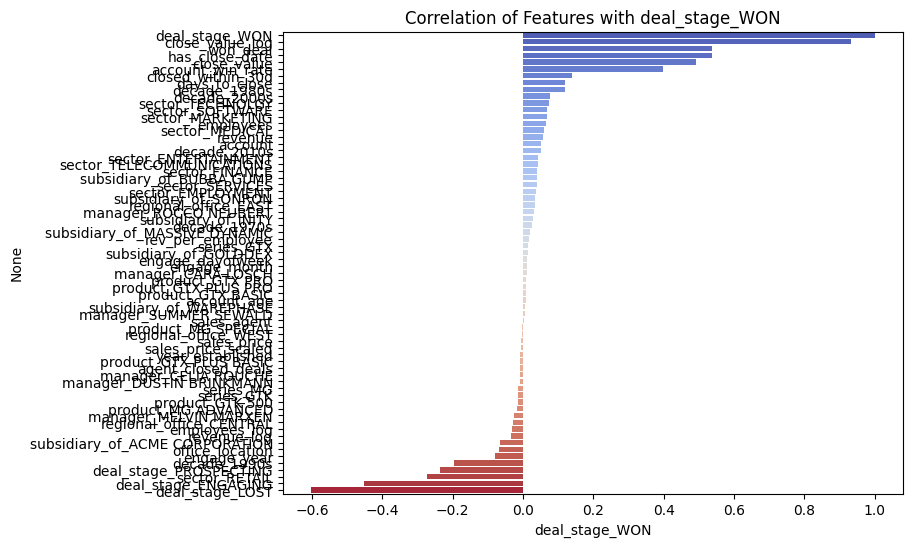

In [32]:
target = "deal_stage_WON"
corr = merged_df.corr(numeric_only=True)[target].sort_values(ascending=False)

plt.figure(figsize=(8,6))
sns.barplot(x=corr, y=corr.index, palette="coolwarm")
plt.title(f"Correlation of Features with {target}")
plt.show()

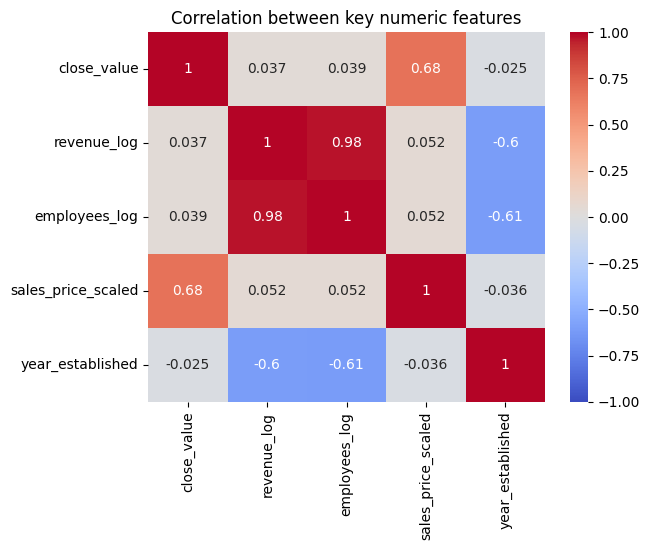

In [33]:
keep = ['close_value','revenue_log','employees_log','sales_price_scaled',
        'year_established']  # adjust as needed
sub = merged_df[ [c for c in keep if c in merged_df.columns] ].select_dtypes(include=[np.number])
sns.heatmap(sub.corr(), annot=True, vmin=-1, vmax=1, cmap='coolwarm')
plt.title('Correlation between key numeric features')
plt.show()